# Movie Recommendation Engine
## Recommendation engine are Basically of three types
        Popularity Based-These recommend the most popular items to user and these have applicationssuch as in  News Websites
        Content Based - These are Based on the Description of the product 
        Collabrative Filtering-These can be of two types User Based and Item Based
                                     User Based-This is based out of  Similarity between users
                                     Item Based-This takes into account the  Similarity between items
                                   

In [1]:
cd C:\Users\HP-15\Documents\TMDB movie dataset

C:\Users\HP-15\Documents\TMDB movie dataset


In [2]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import wordnet as wn
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

c:\users\hp-15\appdata\local\programs\python\python35\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Here we change new columns to match with the IMDB dataset 

In [3]:
import json
import pandas as pd
#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies


In [4]:
movies=load_tmdb_movies('tmdb_5000_movies.csv')
credits=load_tmdb_credits('tmdb_5000_credits.csv')
df_initial = convert_to_original_format(movies, credits)

### Let's Investigate the Null values in Various columns

In [5]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column_type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().apply(lambda x:len([w for w in x if w==True]))).T.rename({0:'null_values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().apply(lambda x:len([w for w in x if w==True])/len(x)*100)).T.rename({0:'%null_values'}))

In [60]:
tab_info


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column_type,int64,object,object,int64,object,object,object,object,float64,object,...,object,object,float64,int64,float64,object,object,object,object,object
null_values,0,0,3091,0,0,86,0,3,0,0,...,844,0,0,0,1,174,30,53,63,93
%null_values,0,0,64.3556,0,0,1.79055,0,0.062461,0,0,...,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


####  Keywords are one the most Important Keywords of our Recommendation engine so put in some time in cleaning it.
We start By Finding out a list of unique keywords along with their frequency 

In [5]:
temp=""
for i in df_initial['plot_keywords']:
    temp=temp+'|'+i
    
keywords=set(temp.split('|'))
keywords.remove('')
list_keywords=list(keywords)

In [6]:
## function for counting the frequency of unique words in a column
def word_count(df,col):
    temp=""
    for i in df[col]:
        temp=temp+'|'+i
    
    keywords=set(temp.split('|'))
    if '' in list(keywords):
        keywords.remove('')
    liste=list(keywords)
    dict_key={}
    keywords=[]
    for i in liste:
        dict_key[i]=[]
    lt=temp.split("|")
    for i in liste:
        j=0
        for w in lt:
            if w==i:
                j=j+1
        dict_key[i].append(j)
    for i in liste:
        keywords.append([i,dict_key[i][0]])
    keywords=sorted(keywords,key=lambda x:x[1],reverse=True)
    
    
 
    return keywords
            
        
        
        

In [7]:
keyword_occurences=word_count(df_initial,'plot_keywords')

In [8]:
len(keyword_occurences)

9813

Different Keywords with thier Frequencies which has a total  of 9813 unique Keywords

In [9]:
keyword_occurences

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189],
 ['aftercreditsstinger', 170],
 ['violence', 150],
 ['dystopia', 139],
 ['sport', 126],
 ['revenge', 118],
 ['sex', 111],
 ['friendship', 106],
 ['musical', 105],
 ['biography', 105],
 ['teenager', 99],
 ['3d', 98],
 ['love', 95],
 ['sequel', 94],
 ['suspense', 92],
 ['new york', 89],
 ['police', 84],
 ['los angeles', 81],
 ['high school', 80],
 ['alien', 76],
 ['prison', 72],
 ['nudity', 71],
 ['family', 69],
 ['superhero', 69],
 ['london england', 69],
 ['drug', 69],
 ['dying and death', 66],
 ['father son relationship', 65],
 ['daughter', 61],
 ['world war ii', 58],
 ['kidnapping', 57],
 ['wedding', 57],
 ['remake', 56],
 ['serial killer', 56],
 ['suicide', 56],
 ['magic', 55],
 ['friends', 54],
 ['corruption', 53],
 ['escape', 52],
 ['party', 52],
 ['based on comic book', 52],
 ['hospital', 52],
 ['martial arts', 51],
 ['time travel', 51],
 ['based on tr

## Word Cloud and Histogram Representation of Famous Keywords

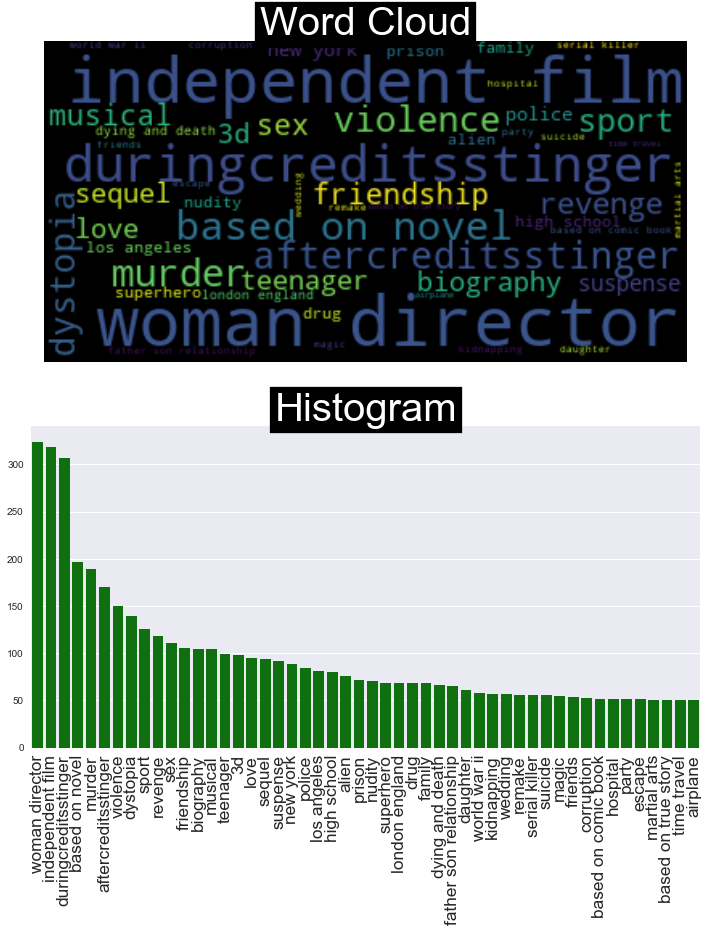

In [9]:
top=keyword_occurences[:50]
dict_key={}
for i in keyword_occurences[:50]:
    dict_key[i[0]]=i[1]
plt.figure(figsize=(12,13))
plt.subplot(211)
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict_key)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud',size=40,bbox={'facecolor':'k','pad':5},color='w')
plt.axis('off')

plt.subplot(212)
x=[i[0] for i in top]
y=[i[1] for i in top]
sns.barplot(x=x,y=y,color='green')
plt.xticks(fontsize='x-large',rotation='vertical')
plt.title('Histogram',size=40,bbox={'facecolor':'k','pad':5},color='w')



plt.show()

### Along with Keywords we also need Genres so let's use the above function to get the unique genres along with their frequency.

In [10]:
temp=""
for i in df_initial['genres']:
    temp=temp+'|'+i
    
genres=set(temp.split('|'))
genres.remove('')
list_genres=list(genres)

In [11]:
genre_freq=word_count(df_initial,'genres')

In [12]:
len(genre_freq)

20

There are a total of 20 genres so we don't hvae to clean this

In [65]:
genre_freq

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894],
 ['Adventure', 790],
 ['Crime', 696],
 ['Science Fiction', 535],
 ['Horror', 519],
 ['Family', 513],
 ['Fantasy', 424],
 ['Mystery', 348],
 ['Animation', 234],
 ['History', 197],
 ['Music', 185],
 ['War', 144],
 ['Documentary', 110],
 ['Western', 82],
 ['Foreign', 34],
 ['TV Movie', 8]]

### Now there are keywords which share the same rootword so let's combine them together 

In [13]:

porter= nltk.PorterStemmer()
def word_converter(df,col):
    temp=""
    for i in df[col]:
        temp=temp+'|'+i
    
    genres=set(temp.split('|'))
    if '' in list(genres):
        genres.remove('')
    liste=list(genres)
    keyword_roots={}
    keyword_select={}
    for s in liste:
        root=porter.stem(s)
        if root not in keyword_roots.keys():
            keyword_roots[root]=[s]
        else:
            keyword_roots[root].append(s)
    for s in keyword_roots.keys():
                   
        if len(keyword_roots[s])>1:
            min_length=10000
            for k in keyword_roots[s]:
                if len(k)<min_length:
                    lth=k
                    min_length=len(k)
            keyword_select[s]=lth
        else:
            keyword_select[s]=keyword_roots[s][0]
     
       
    return keyword_roots,keyword_select
        

In [16]:
keyword_roots,keyword_select=word_converter(df_initial,'plot_keywords')

Let's peak into the different set of root keywords available with us and words associated with them.

In [17]:
keyword_roots

{'family curs': ['family curse'],
 'shot in the back': ['shot in the back'],
 'bare knuckle box': ['bare knuckle boxing'],
 'criminal lawy': ['criminal lawyer'],
 'space rac': ['space race'],
 'waterloo': ['waterloo'],
 'prosthetic arm': ['prosthetic arm'],
 'southwestern u.s.': ['southwestern u.s.'],
 'hawaii': ['hawaii'],
 'condominium': ['condominium'],
 'invest': ['investment'],
 'security guard': ['security guard'],
 'elephant s': ['elephant seal'],
 'assassination attempt': ['assassination attempt'],
 'convenience store robberi': ['convenience store robbery'],
 'subcultur': ['subculture'],
 'joint': ['joint'],
 'xenophobia': ['xenophobia'],
 'comanch': ['comanche'],
 'wander': ['wanderer'],
 'locker': ['locker'],
 'sin': ['sin'],
 'penthouse apart': ['penthouse apartment'],
 'manila philippin': ['manila philippines'],
 'police depart': ['police department'],
 'male virgin': ['male virgin'],
 'surfer dud': ['surfer dude'],
 'skylight': ['skylight'],
 'dead broth': ['dead brother']

Now for  the roots which have Multiple words associated with it, we choose one word which has the shortest length and assign all  other words of the same pool to that word.Hence increasing the frequency of the selected word and eliminating the others.

In [18]:

keyword_select

{'family curs': 'family curse',
 'shot in the back': 'shot in the back',
 'bare knuckle box': 'bare knuckle boxing',
 'criminal lawy': 'criminal lawyer',
 'space rac': 'space race',
 'waterloo': 'waterloo',
 'prosthetic arm': 'prosthetic arm',
 'southwestern u.s.': 'southwestern u.s.',
 'hawaii': 'hawaii',
 'condominium': 'condominium',
 'invest': 'investment',
 'tree hous': 'tree house',
 'snoop': 'snooping',
 'elephant s': 'elephant seal',
 'expert': 'expert',
 'small town thiev': 'small town thieves',
 'xenophobia': 'xenophobia',
 'comanch': 'comanche',
 'business woman': 'business woman',
 'sin': 'sin',
 'penthouse apart': 'penthouse apartment',
 'manila philippin': 'manila philippines',
 'police depart': 'police department',
 'male virgin': 'male virgin',
 'surfer dud': 'surfer dude',
 'skylight': 'skylight',
 'starfleet': 'starfleet',
 'dalai lama': 'dalai lama',
 'self-referenti': 'self-referential',
 'x-ray': 'x-ray',
 'oil tycoon': 'oil tycoon',
 'fellatio': 'fellatio',
 'tv s

In [20]:
## Now that we have cleaned keywords let's replace them by the selected (as discussed above) keywords in the original Data Frame
def cleaned_dataframe(df,keyword_select,roots=True):
    df_cleaned=df.copy()
    for index,row in df_cleaned.iterrows():
        liste=[]
        t=row['plot_keywords']
        if pd.isnull(t):continue
        keys=t.split('|')
        for s in keys:
            root=porter.stem(s) if roots else s
            if root in keyword_select.keys():
                liste.append(keyword_select[root])
            else:
                liste.append(s)

        df_cleaned.set_value(index,'plot_keywords',"|".join(liste))
                   
    return df_cleaned
        

In [21]:
df_cleaned=cleaned_dataframe(df_initial,keyword_select)

In [22]:
keyword_occurences_filtered=word_count(df_cleaned,'plot_keywords')

In [23]:
key_filter=keyword_occurences_filtered
len(key_filter)

9473

Here we see that the new Dataframe has a length of 9473 keywords .

In [24]:
keyword_occurences_filtered

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['murder', 197],
 ['based on novel', 197],
 ['aftercreditsstinger', 170],
 ['music', 151],
 ['violence', 150],
 ['dystopia', 139],
 ['sport', 126],
 ['revenge', 118],
 ['sex', 111],
 ['friendship', 106],
 ['biography', 105],
 ['teenager', 99],
 ['3d', 98],
 ['love', 95],
 ['sequel', 94],
 ['suspense', 93],
 ['new york', 89],
 ['prison', 87],
 ['police', 84],
 ['alcohol', 82],
 ['los angeles', 81],
 ['high school', 80],
 ['alien', 80],
 ['drug', 72],
 ['nudity', 71],
 ['assassin', 70],
 ['family', 69],
 ['superhero', 69],
 ['london england', 69],
 ['dying and death', 66],
 ['father son relationship', 65],
 ['daughter', 61],
 ['friend', 59],
 ['suicide', 59],
 ['world war ii', 58],
 ['kidnapping', 57],
 ['serial kiler', 57],
 ['wedding', 57],
 ['remake', 56],
 ['explosive', 55],
 ['magic', 55],
 ['fight', 54],
 ['corruption', 53],
 ['time travel', 53],
 ['party', 53],
 ['escape', 52],
 ['based on comic

In [149]:
df_initial['plot_keywords'][4774]

'dream|prostitution'

Now further working on the cleaning of the keywords we replace the words having  Frequency less than 5 with words that share the same meaning but have higher frequency.

In [29]:
## functions for getting a synonym of a word and herewe are considering only Nouns.
def get_synonyms(word):
    sys=wn.synsets(word)
    synonyms=set()
    if not len(sys)==0:
        for w in sys:
            if w.name().split('.')[1]=='n':
                for i in w.lemmas():
                    synonyms.add(i.name())
    return list(synonyms)
    
    

This function replaces the words with low Frequency with their synonyms of higher fequency and give a list of equal_synoyms which have same low frequency 

In [31]:

def synonym_replace_lessthan(liste,alpha):
    dict_liste={}
    for w in liste:
        dict_liste[w[0]]=w[1]
    replace={}
    replacement=[]
    equal_synonyms=[]
    freq=[w[0] for w in liste if w[1]<alpha]
    for w in freq:
        col=[]
        con=[]
        syn=get_synonyms(w)
      
        for s in syn:
            if s in dict_liste.keys():
                    col.append([s,dict_liste[s]])
        d=sorted(col,key=lambda x:x[1],reverse=True)
   
        if len(col)>1:
            if dict_liste[w]<dict_liste[d[0][0]]:
                replace[w]=d[0][0]  
                replacement.append([w,dict_liste[w],d[0][0],dict_liste[d[0][0]]])
            for s in d:
                if dict_liste[s[0]]==dict_liste[w]:
                    con.append(True)
                else:
                    con.append(False)
            if all(con):
                    equal_synonyms.append(d)
        
    return replace,freq,replacement,equal_synonyms
    
    
    

In [28]:
replace_keys,freq,replacement,equal_synonyms=synonym_replace_lessthan(key_filter,5)

In [653]:
ts,fq,rm,es=synonym_replace_lessthan(filter_list,5)

In [29]:
equal_synonyms     


[[['threat', 4], ['menace', 4]],
 [['boss', 3], ['chief', 3]],
 [['interpreter', 3], ['voice', 3]],
 [['cross', 3], ['hybrid', 3]],
 [['stage', 3], ['stagecoach', 3]],
 [['shenanigan', 3], ['mischief', 3]],
 [['bath', 3], ['bathtub', 3]],
 [['cross', 3], ['hybrid', 3]],
 [['stagecoach', 3], ['stage', 3]],
 [['gymnasium', 3], ['gym', 3]],
 [['gymnasium', 3], ['gym', 3]],
 [['legs', 3], ['stage', 3]],
 [['lecture', 3], ['speech', 3]],
 [['safari', 3], ['campaign', 3]],
 [['tension', 3], ['stress', 3]],
 [['tension', 3], ['stress', 3]],
 [['shenanigan', 3], ['mischief', 3]],
 [['dictatorship', 2], ['tyranny', 2]],
 [['dock', 2], ['pier', 2]],
 [['pressure', 2], ['press', 2]],
 [['dock', 2], ['pier', 2]],
 [['canyon', 2], ['canon', 2]],
 [['dreamer', 2], ['idealist', 2]],
 [['joker', 2], ['turkey', 2]],
 [['dictatorship', 2], ['tyranny', 2]],
 [['canyon', 2], ['canon', 2]],
 [['dreamer', 2], ['idealist', 2]],
 [['tooth', 1], ['teeth', 1]],
 [['aura', 1], ['air', 1]],
 [['replacement', 1], 

### treating the equal_synonyms:-
* First we try find a synonym of higher frequency from replace_keys and map  all words of equal_synonyms with that.
* Else we replace all the words with the first word. 

In [34]:

def connect(equal_synonyms,replace_keys,dict_liste):  
    f=replace_keys.copy()
    
    for s in equal_synonyms:
        col=[]
        for w in [i[0] for i in s]:
            if w in replace_keys.keys():
                col.append([replace_keys[w],dict_liste[replace_keys[w]]])
    
        d=sorted(col,key=lambda x:x[1],reverse=True)
        if not len(d)==0: 
               for w in [i[0] for i in s]:
                    f[w]=d[0][0]
        if len(d)==0:
            
            for i in range(1,len(s)):
                if s[i][0] not  in f.keys() and s[i][0] not in f.values():
                    f[s[i][0]]=s[0][0]
    return f
        
            
        
    

In [35]:
dict_keywords={}
for w in key_filter:
    dict_keywords[w[0]]=w[1]
    
second_replace=connect(equal_synonyms,replace_keys,dict_keywords)
second_replace

{'abortion': 'miscarriage',
 'abuse': 'insult',
 'aggression': 'hostility',
 'air': 'aviation',
 'amphetamine': 'speed',
 'amulet': 'talisman',
 'apparition': 'shadow',
 'appeal': 'prayer',
 'approach': 'attack',
 'archeologist': 'archaeologist',
 'arms': 'weapon',
 'artillery': 'gun',
 'artwork': 'art',
 'assurance': 'pledge',
 'audience': 'interview',
 'aura': 'aviation',
 'automaton': 'zombie',
 'autumn': 'fall',
 'avant-garde': 'van',
 'axe': 'ax',
 'babes': 'baby',
 'balance': 'correspondence',
 'band': 'ring',
 'bankruptcy': 'failure',
 'barbarian': 'peasant',
 'base': 'home',
 'bathroom': 'bath',
 'bathtub': 'bath',
 'beast': 'wolf',
 'bias': 'prejudice',
 'bitch': 'beef',
 'bitterness': 'resentment',
 'blackout': 'amnesia',
 'blade': 'sword',
 'blast': 'fire',
 'bloodshed': 'gore',
 'bloodsucker': 'parasite',
 'bodybuilder': 'muscleman',
 'bomber': 'hero',
 'bondage': 'slavery',
 'bookstore': 'bookshop',
 'boss': 'chief',
 'brain': 'genius',
 'breeding': 'education',
 'broker':

Here we come across a situation where
* i is being mapped into j 
* j is bing mapped into k
> So j occurs in both key and value of Second_replace list.To encounter this we map,
* i to k since it has a greater frequenct than j

In [37]:
key_value=list(set(list(second_replace.keys())).intersection(list(second_replace.values())))
key_value

['panther',
 'striptease',
 'crook',
 'club',
 'pest',
 'shadow',
 'heart',
 'record',
 'failure',
 'origin',
 'home',
 'tramp',
 'field',
 'commitment',
 'carnival',
 'bullet',
 'deal',
 'riot',
 'drawing',
 'pot',
 'green']

In [521]:
len([print([replace_keys[w],second_replace[w]]) for w in list(set(second_replace.keys()).intersection(replace_keys.keys()))])

['defense', 'defense']
['medallion', 'medallion']
['pollution', 'pollution']
['nightmare', 'nightmare']
['impersonation', 'impersonation']
['exercise', 'exercise']
['weapon', 'weapon']
['smoke', 'smoke']
['pest', 'pest']
['vomit', 'vomit']
['suicide', 'suicide']
['idol', 'idol']
['defeat', 'defeat']
['castration', 'castration']
['legend', 'legend']
['angel', 'angel']
['disaster', 'disaster']
['sewer', 'sewer']
['commitment', 'commitment']
['hitman', 'hitman']
['cinema', 'cinema']
['brother', 'brother']
['manager', 'manager']
['puppet', 'puppet']
['enchantment', 'enchantment']
['passion', 'passion']
['work', 'work']
['apartment', 'apartment']
['infidelity', 'infidelity']
['passion', 'passion']
['penalty', 'penalty']
['curse', 'curse']
['corruption', 'corruption']
['green', 'green']
['plan', 'plan']
['pot', 'pot']
['change', 'change']
['bell', 'bell']
['pastor', 'pastor']
['origin', 'origin']
['documentary', 'documentary']
['satire', 'satire']
['attic', 'attic']
['farewell', 'farewell']


407

In [38]:
key_value=list(set(list(second_replace.keys())).intersection(list(second_replace.values())))
while(len(key_value)>0):
    key_value=list(set(list(second_replace.keys())).intersection(list(second_replace.values())))
    i=list(second_replace.values())
    for s in list(second_replace.keys()):
        if s in key_value:
            second_replace[list(second_replace.keys())[i.index(s)]]=second_replace[s]
        
        
    
    

In [ ]:
len(second_re)

###  Now we replace the words with their synonyms and create a new list of unique keywords of length

In [39]:
def replace_synonyms(replace_dict,liste):
    dict_liste={}
    for w in liste:
        dict_liste[w[0]]=w[1]
    filtered={}
    filter_list=[]
    for w in dict_liste.keys():
        if w not in replace_dict.keys():
            filtered[w]=dict_liste[w]
    for w in replace_dict.keys():
        filtered[replace_dict[w]]= filtered[replace_dict[w]]+dict_liste[w]
    for w in filtered.keys():
        filter_list.append([w,filtered[w]])
    filter_list=sorted(filter_list,key=lambda x:x[1],reverse=True)
        
        
    return filtered,filter_list
            

In [40]:
filter_dict,filter_list=replace_synonyms(second_replace,key_filter)

In [41]:
df_cleaned2=cleaned_dataframe(df_cleaned,second_replace,roots=False)

In [42]:
processed_keywords=word_count(df_cleaned2,'plot_keywords')

In [30]:
len(processed_keywords)

8993

In [118]:
processed_keywords[:10]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197],
 ['aftercreditsstinger', 170],
 ['music', 151],
 ['violence', 150],
 ['dystopia', 139],
 ['sport', 128]]

In [44]:
## function for removing words with frequency lower than certain threshold
def frequency_lessthan(liste,alpha):
    new_list=[]
    for w in liste:
        if w[1]>alpha:
            new_list.append(w)
    return new_list
            
        

### Futher Processing Keywords we drop the keywords with frequency lower than 3

In [119]:
new_keyword_occurences=frequency_lessthan(processed_keywords,3)
new_keyword_occurences[:10]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197],
 ['aftercreditsstinger', 170],
 ['music', 151],
 ['violence', 150],
 ['dystopia', 139],
 ['sport', 128]]

In [121]:
## Creating A new dataframe with supressed Keywords
def supress_keywords(df,supress_keywords):
    new_df=df.copy()
    dict_supress={}
    for i in supress_keywords:
        dict_supress[i[0]]=i[1]
    for index,row in new_df.iterrows():
        col=[i for i in row['plot_keywords'].split("|") if i in dict_supress.keys()]
        new_df.set_value(index,'plot_keywords',"|".join(col))
        
    return new_df
        
    

In [108]:
df_cleaned3=supress_keywords(df_cleaned2,new_keyword_occurences)


In [110]:
keyword_list=word_count(df_cleaned3,'plot_keywords')

In [111]:
len(keyword_list)

2154

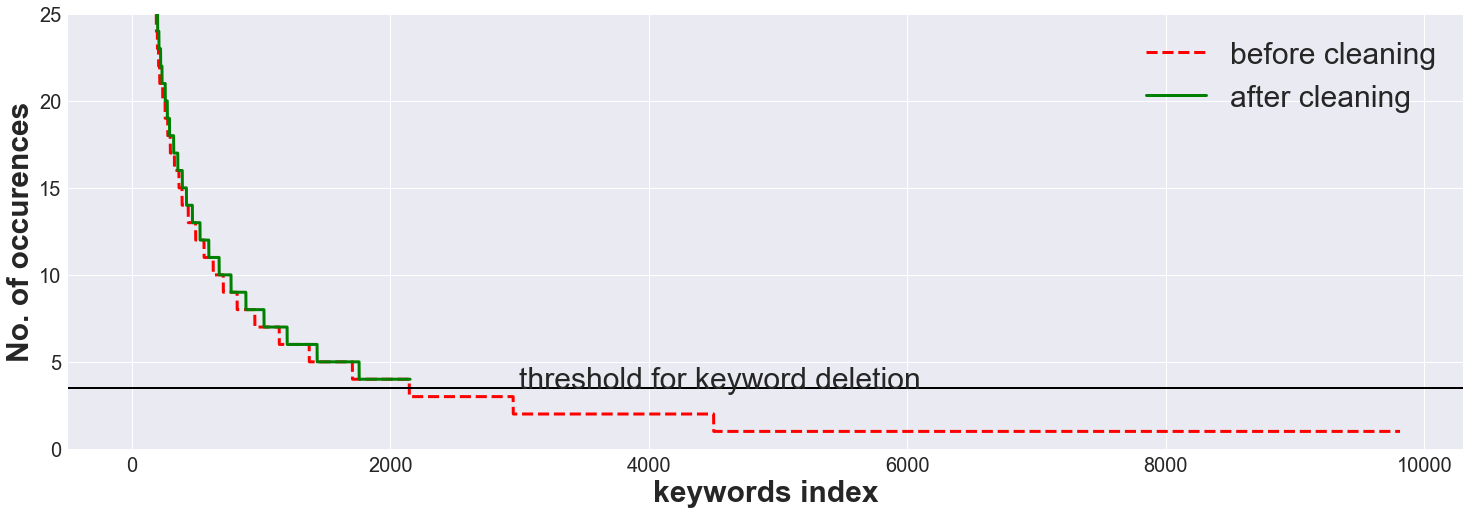

In [725]:
plt.figure(figsize=(25,8))
x=list(range(1,len(keyword_occurences)+1))
y=[i[1] for i in keyword_occurences]
new_xaxis=list(range(1,len(new_keyword_occurences)+1))
new_yaxis=[i[1] for i in new_keyword_occurences]
plt.plot(x,y,'r--',label='before cleaning',linewidth=3.0)
plt.plot(new_xaxis,new_yaxis,'green',label='after cleaning',linewidth=3.0)
plt.xlabel('keywords index',size=30,weight='bold')
plt.ylabel('No. of occurences',size=30,weight='bold')
plt.axhline(y=3.5,linewidth=2.0,color='black')
plt.text(3000,3.5,'threshold for keyword deletion',fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='upper right',fontsize=30)
plt.ylim(0,25)## to zoom in the plot
plt.show()

### Cleaning other columns of the DataFrame

In [122]:
df_var_cleaned=df_cleaned3.copy()
s=df_var_cleaned.isnull().sum(axis=0).reset_index()
s.columns=['column_name','missing_values']
s.sort_values('missing_values',ascending=False,inplace=True)
s['filling_factor']=(df_var_cleaned.shape[0]-s['missing_values']) / df_var_cleaned.shape[0] * 100
s=s.reset_index(drop=True)
missing_df=s.copy()
missing_df[:10]

,column_name,missing_values,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


# Recommendation Engine

## Basic functioning of the engine

order to build the recommendation engine, I will basically proceed in two steps:

1. determine  N films with a content similar to the entry provided by the user
2. select the 5 most popular films among these  N  films

### **Similarity**

When builing the engine, the first step thus consists in defining a criteria that would tell us how close two films are. To do so, I start from the description of the film that was selected by the user: from it, I get the director name, the names of the actors and a few keywords. I then build a matrix where each row corresponds to a film of the database and where the columns correspond to the previous quantities (director + actors + keywords) plus the k genres that were describe above.
 
 Now that we have our first N movies we need to recommend 5 movies to the user.
 According to similarities between entries, we get a list of  NN  films. At this stage, I select 5 films from this list and, to do so, I give a score for every entry. I decide de compute the score according to 3 criteria:

 1. the IMDB score
 2. the number of votes the entry received
 3. the year of release
 
The two first criteria will be a direct measure of the popularity of the various entries in IMDB. For the third criterium, I introduce the release year since the database spans films from the early  XXthXXth  century up to now. 
I assume that people's favorite films will be most of the time from the same epoch.
$score=IMDB^2 X ϕ_{σ1,c1} X ϕ_{σ2,c2}$

$ϕ_{σ,c}(x)∝exp(−(x−c)^2/2σ^2)$

In [60]:
## This functuion retrievs the labels of the movie entered by the user 
def add_entry(df,id_entry):
    col_labels=[]
    index=list(df['id']).index(id_entry)
    columns=['director_name','actor_1_name','actor_2_name','actor_3_name','plot_keywords','genres']
    for s in columns:
        if pd.isnull(df[s].iloc[index]):continue
        a=df[s].iloc[index].split("|")
        for i in a:
            col_labels.append(i)
    return col_labels


In [47]:
df_initial

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'id': 289, 'name': 'Ingenious Film Partners'...",...,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...",...,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'id': 923, 'name': 'Legendary Pictures'}, {'...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'id': 2, 'name': 'Walt Disney Pictures'}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...",...,The battle within.,Spider-Man 3,5.9,3576,2007.0,United States of America,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...",...,They're taking adventure to new lengths.,Tangled,7.4,3330,2010.0,United States of America,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'id': 420, 'name': 'Marvel Studios'}, {'id':...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'id': 6194, 'name': 'Warner Bros.'}, {'id': ...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,Davi

In [61]:
## This cretaes a datframe including all the  variables given by the add_entry as columns
def new_dataframe(df,ref_var):
    for s in ref_var:df[s]=pd.Series([0 for i in range(len(df_initial))])
    columns=['director_name','actor_1_name','actor_2_name','actor_3_name','plot_keywords','genres']
    for col in columns:
        for index,row in df.iterrows():
            if pd.isnull(row[col]):continue
            t=row[col].split('|')
            for s in t:
                if s in ref_var:df.set_value(index,s,1)
                
    return df
    
    

 This functions returns a list of 30 films which were nearest to the movie entered by the user . It uses **Euclidean distance** for this Calculation
 $Distance=\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2+..}$

In [62]:
def make_recommendation(df,id_entry):
    index=list(df['id']).index(id_entry)
    ref_var=add_entry(df,id_entry)
    new_df=new_dataframe(df,ref_var)
    X=new_df.as_matrix(ref_var)
    nearest=NearestNeighbors(n_neighbors=31,algorithm='auto',metric='euclidean').fit(X)
    xtest=new_df.iloc[index,:].as_matrix(ref_var)
    xtest=xtest.reshape(1,-1)
    distance,indices=nearest.kneighbors(xtest)
    indices=indices.ravel()
    return indices   

In [65]:
## Once we have the list of 30 films we extract the variables as stataed above to calculate the score for each movie
def feature_extractor(df,film_indices,id_entry):
    index=list(df['id']).index(id_entry)
    parametre_list=[]
    scores=[]
    col=['vote_average','title_year','num_voted_users','original_title']
    for s in film_indices:
        parametre_list.append(df.iloc[s,:][col].values)
    maximum=0
    for s in parametre_list:
        if s[2]>maximum:
            maximum=s[2]
    title_year_ref=df.iloc[index,:]['title_year']
    for s in parametre_list:
        sc=criterion(s[0],s[1],s[2],s[3],maximum,title_year_ref)
        scores.append([s[3],sc])
    scores.sort(key=lambda x:x[1],reverse=False)
    return parametre_list
    

In [75]:
gaussian_filter = lambda x,mu,sigma: 1./(np.sqrt(2.*np.pi)*sigma)*np.exp(-np.power((x - mu)/sigma, 2.)/2)

In [69]:
def criterion(vote_average,title_year,num_voted_users,original_title,maximum,title_year_ref):
    if pd.notnull(vote_average):
        feature1=vote_average
    else:
        feature1=0
    if pd.notnull(title_year):
        feature2=gaussian_filter(title_year,title_year_ref,20)
    else:
        feature2=0
    
    if pd.notnull(num_voted_users):
        feature3=num_voted_users**2
    else:
        feature3=0
    score=feature1**2*feature2*feature3
    return score
    
    

In [95]:
def get_id_entry(title):
    
    index=list(df_var_cleaned['original_title']).index(title)
    return df_var_cleaned['id'].iloc[index]

In [93]:
## This is the final functions which recommends the movie
def recommend_movies(df,title,sequal=False):
    selected=[]
    id_entry=get_id_entry(title)
    
    col_labels=add_entry(df,id_entry)
    film_indices=make_recommendation(df,id_entry)
    parametre_list=feature_extractor(df,film_indices,id_entry)
    for s in parametre_list[:5]:
        selected.append(s[3])
    if sequal==False:selected=remove_sequal(df,parametre_list,id_entry)
    
    
    return selected

In [80]:
def check_sequal(title,title_ref):
    if (fuzz.ratio(title,title_ref) or fuzz.token_sort_ratio(title,title_ref))>60:
        return True
    else:
        return False

Many a times recommending a sequal of the movie entered by the user might come of as dumb recommendation, so we remove alll sequals and just give out the most popular sequal

In [71]:

def remove_sequal(df,parametre_list,id_entry):
    index=list(df['id']).index(id_entry)
    title_ref=df['original_title'].iloc[index]
    sequal_list=[]
    film_list=[]
    selected=[]
    a=[]
    for i in parametre_list:
        if check_sequal(i[3],title_ref):
            index=list(df['original_title']).index(i[3])
            sequal_list.append([i[3],df['popularity'].iloc[index]])
    c=0

    names,score=zip(*sequal_list)
    for i in parametre_list:
        if c<5:
            if  not i[3] in names:
                film_list.append(i[3])
                a.append(i[3])
                c+=1
    if len(sequal_list)>0:
        sequal_list.sort(key=lambda x:x[1],reverse=True)
        selected.append(sequal_list[0][0])
        for i in film_list[:4]:
            selected.append(i)
        return selected
    else:
        return film_list         

In [90]:
df_var_cleaned

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,alliance,calypso,afterlife,fighter,pirate,swashbuckler,aftercreditsstinger,Adventure,Fantasy,Action
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'id': 289, 'name': 'Ingenious Film Partners'...",...,0,0,0,0,0,0,0,1,1,1
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...",...,1,1,1,1,1,1,1,1,1,1
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...",...,0,0,0,0,0,0,0,1,0,1
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'id': 923, 'name': 'Legendary Pictures'}, {'...",...,0,0,0,0,0,0,0,0,0,1
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'id': 2, 'name': 'Walt Disney Pictures'}]",...,0,0,0,0,0,0,0,1,0,1
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'id': 5, 'name': 'Columbia Pictures'}, {'id'...",...,0,0,0,0,0,0,0,1,1,1
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|music|princess|...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'id': 2, 'name': 'Walt Disney Pictures'}, {'...",...,0,0,0,0,0,0,0,0,0,0
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'id': 420, 'name': 'Marvel Studios'}, {'id':...",...,0,0,0,0,0,0,0,1,0,1
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'id': 6194, 'name': 'Warner Bros.'}, {'id': ...",...,0,0,0,0,0,0,0,1,1,0
9,250000000,Action|Adventure|Fantasy,http://www.batmanvsupermandawnofjustice.com/,209112,dc comics|vigilante|superhero|based on comic b...,English,Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super Hero l...,155.790452,"[{'id': 429, 'name': 'DC Comics'}, {'id': 507,...",...,0,0,0,0,0,0,0,1,1,1


## Let's Use of Our Recommendation Engine to make some recommendations

In [94]:
recommend_movies(df_var_cleaned,"Avatar",sequal=True)

['Avatar',
 'Star Trek Into Darkness',
 'The Fifth Element',
 'Jimmy Neutron: Boy Genius',
 'Predators']

In [96]:
recommend_movies(df_var_cleaned,"Pirates of the Caribbean: At World's End")

['Pirates of the Caribbean: The Curse of the Black Pearl',
 "Nim's Island",
 'Cutthroat Island',
 'In the Heart of the Sea',
 'Shrek the Third']

In [97]:
recommend_movies(df_var_cleaned,"Pirates of the Caribbean: At World's End",sequal=True)

["Pirates of the Caribbean: At World's End",
 "Pirates of the Caribbean: Dead Man's Chest",
 'Pirates of the Caribbean: The Curse of the Black Pearl',
 'Pirates of the Caribbean: On Stranger Tides',
 "Nim's Island"]

In [115]:
recommend_movies(df_var_cleaned,"Spectre")

['Spectre',
 'Skyfall',
 'Johnny English Reborn',
 'Quantum of Solace',
 'The Spy Who Loved Me']

In [102]:
recommend_movies(df_var_cleaned,"Bound")

['Bound', 'Witness', 'Double Jeopardy', 'The Limey', 'GoodFellas']

# Future Work
* Here I have used euclidean distance we can Other Distances as well such as jacradian distance.
* One can use other methods to Calculate the score.
* We can consider production country as well Because user might want movie from the same country to be recommended and even language.


